<a href="https://colab.research.google.com/github/shubham2007-pro/5CS037/blob/main/2501563_Shubham_Pant_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Portfolio Project - Regression Task  
# California Housing Price Prediction

**Student Name:** Shubham Pant  
**UID:** 2501563  
**Course:** Concepts and Technologies of AI (5CS037)  
**Module:** Final Portfolio Project (Regression)  
**Submission Date:** 10 Feb 2026  

---

> **UNSDG Alignment:** **SDG 11 — Sustainable Cities and Communities**  
This project predicts housing prices based on urban features (location, size, rooms), supporting sustainable urban planning and housing affordability analysis.


#California Housing Price Prediction
(Aligns with: UN SDG 11 – Sustainable Cities & Communities)

#**1. IMPORT LIBRARIES**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS


## 1.1 Dataset Description and Motivation

**Dataset name:** `california_regression.csv`  
**Source:** Derived from the California Housing dataset (Kaggle/Scikit-learn).

**Motivation:**
Understanding housing market trends is essential for achieving **SDG 11**. By predicting prices based on geographical and structural attributes, we can gain insights into urban development patterns and housing accessibility.

**Attributes Table:**
| Attribute | Description |
| :--- | :--- |
| price | Target: Sale price of the house |
| bed | Number of bedrooms |
| bath | Number of bathrooms |
| acre_lot | Size of the lot in acres |
| house_size | Living area square footage |
| city/state/zip | Geographical location identifiers |


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv("/content/drive/MyDrive/Assignment3/california_regression.csv")

In [24]:
df.head(10)  #First 10 rows of the dataset

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


In [25]:
# Last 5 rows
df.tail()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354.0,3600.0,2022-03-25
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354.0,1616.0,2022-03-25
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354.0,3200.0,2022-03-24
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354.0,933.0,2022-03-24
2226381,108243.0,sold,580000.0,5.0,3.0,0.31,307704.0,Richland,Washington,99354.0,3615.0,2022-03-23


In [26]:
#Number of rows and columns
print("Dataset Shape:", df.shape)

Dataset Shape: (2226382, 12)


# **3. DATA CLEANING & PREPROCESSING**

**Handling Missing Values and Outliers**

In [27]:
# Removing rows where target variable (price) is missing
df = df.dropna(subset=["price"])

In [28]:
# Dropping missing values
df=df.dropna()

In [29]:
# Dropping irrelevant columns
df = df.drop(columns=["prev_sold_date", "brokered_by"], errors="ignore")

In [30]:
# Removing rows missing key numerical features
df = df.dropna(subset=["house_size", "bed", "bath"])

In [31]:
# Removing duplicates
df = df.drop_duplicates()

Removing Unrealistic Values

In [32]:
# Removing unrealistic values using logical limits
df_clean = df[
    (df["bed"].between(0, 10)) &
    (df["bath"].between(0, 10)) &
    (df["house_size"].between(200, 10000))
]


In [33]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return data[(data[column] >= lower) & (data[column] <= upper)]

for col in ["bed", "bath", "house_size"]:
    df = remove_outliers_iqr(df, col)


In [34]:
for col in ["bed", "bath", "house_size"]:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [35]:
# Columns to treat for outliers
cols = ['price', 'acre_lot', 'house_size']

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) &
                            (df_clean[col] <= upper_bound)]

        print(f"{col}: kept {df_clean.shape[0]} rows")

    return df_clean

df = remove_outliers_iqr(df, cols)

price: kept 896736 rows
acre_lot: kept 765241 rows
house_size: kept 758132 rows


In [36]:
df=df.dropna()

In [37]:
# Checking the structure of the dataset after cleaning
print("Cleaned Shape:", df.shape)

Cleaned Shape: (758132, 10)


# **4. EXPLORATORY DATA ANALYSIS (EDA)**

**Histograms**

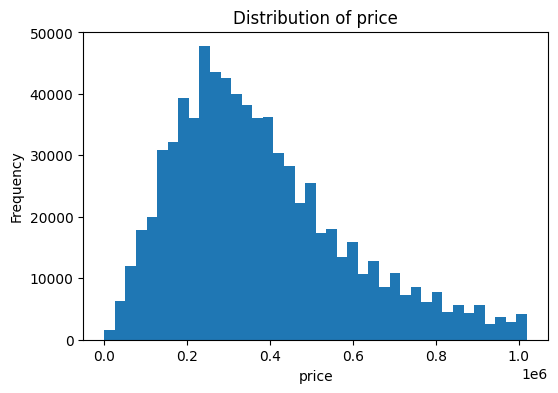

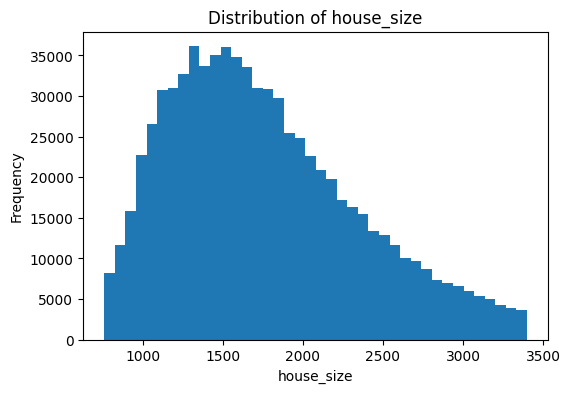

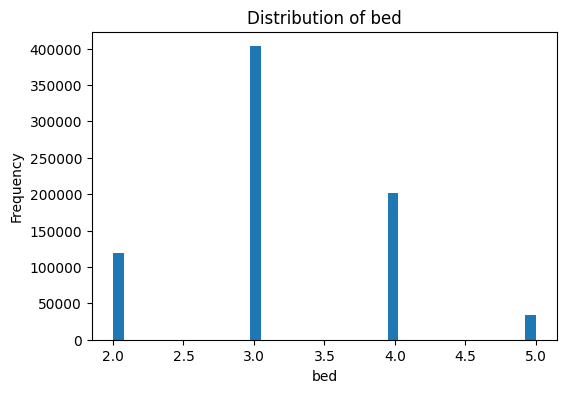

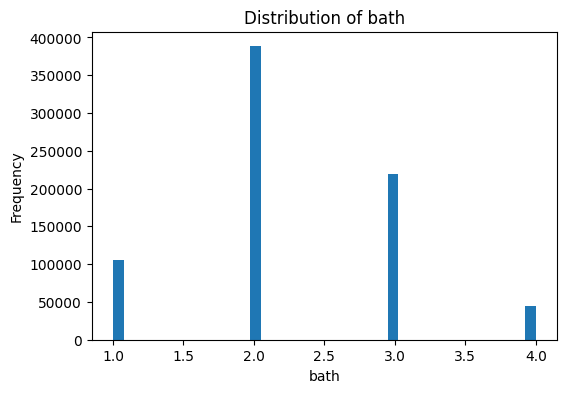

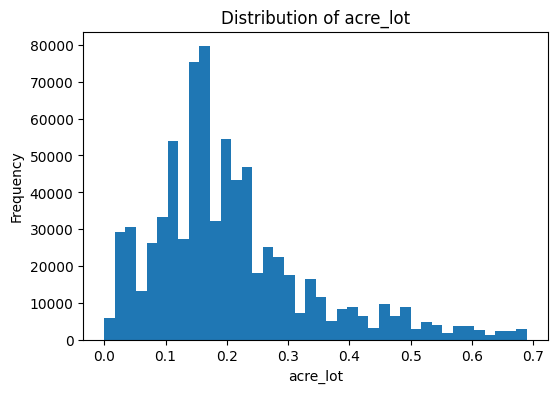

In [38]:
numeric_cols = ["price", "house_size", "bed", "bath", "acre_lot"]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.savefig(f"{col}_histogram.png")
    plt.show()


**Boxplots (Outlier detection)**



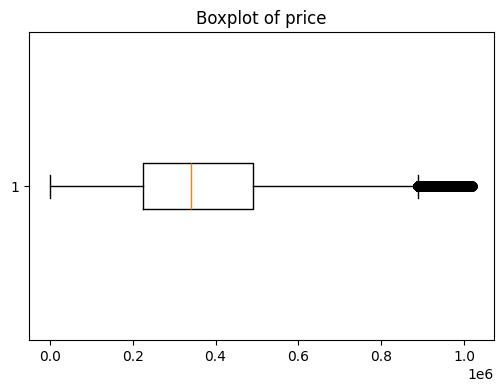

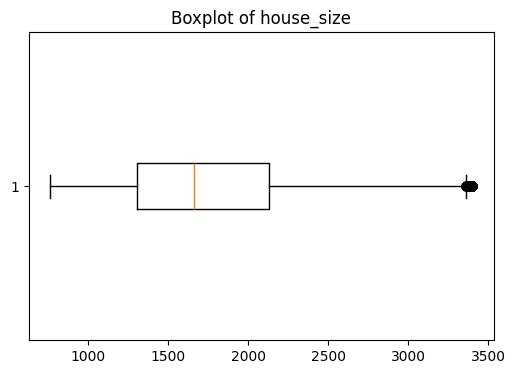

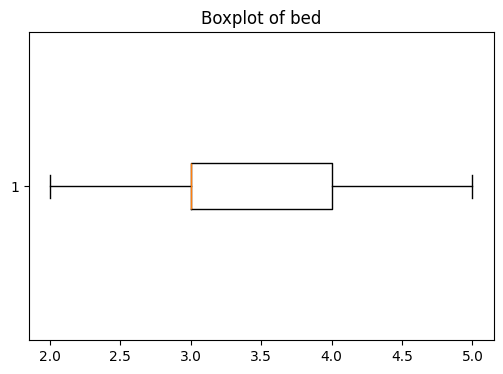

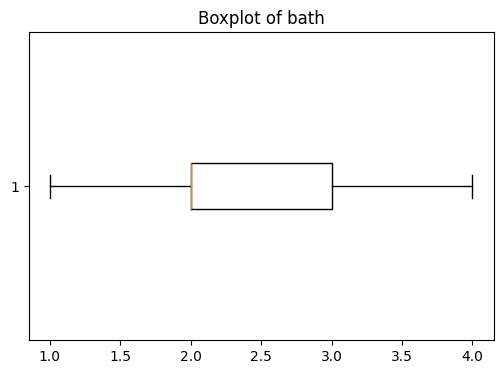

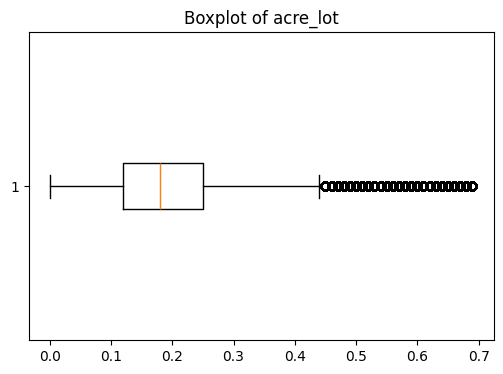

In [39]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.savefig(f"{col}_boxplot.png")
    plt.show()


**Correlation Heatmap**

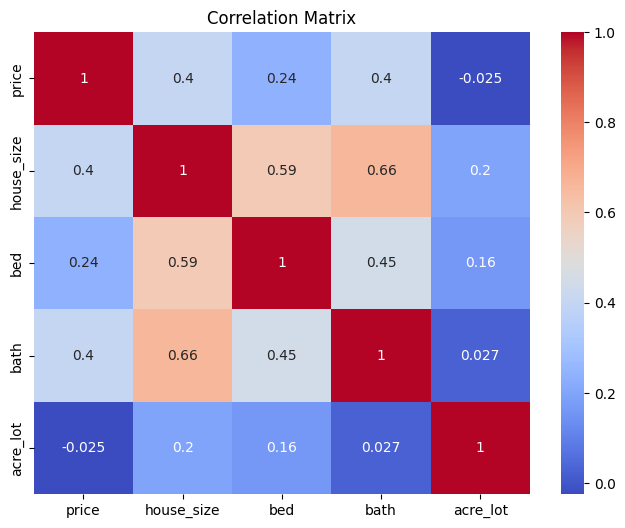

In [40]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("correlation_heatmap.png")
plt.show()


**Scatter plots vs target**

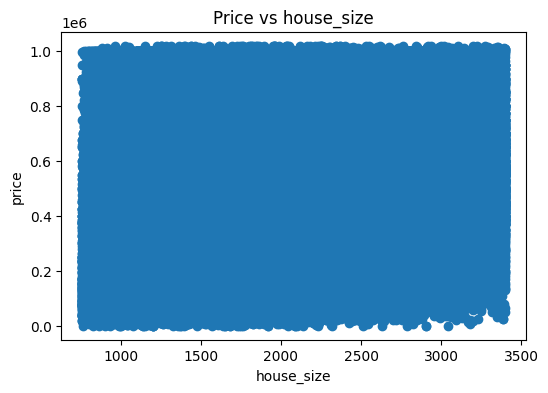

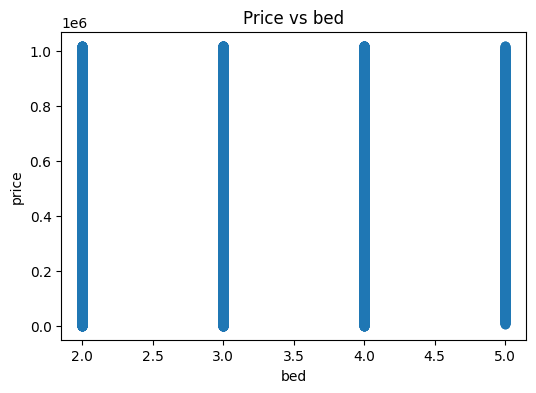

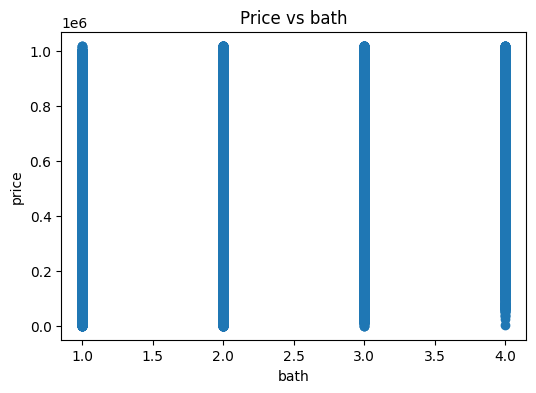

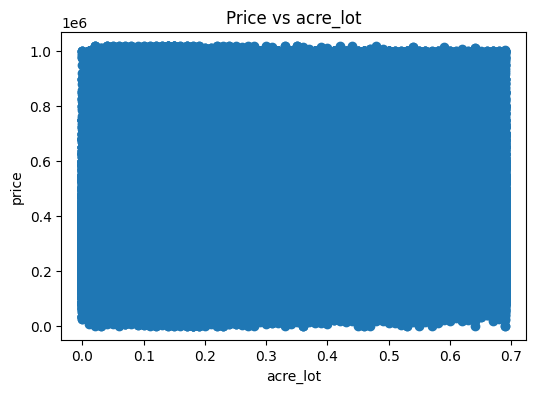

In [41]:
features = ["house_size", "bed", "bath", "acre_lot"]

for col in features:
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df["price"])
    plt.xlabel(col)
    plt.ylabel("price")
    plt.title(f"Price vs {col}")
    plt.savefig(f"{col}_price_scatter.png")
    plt.show()


**Price by status**

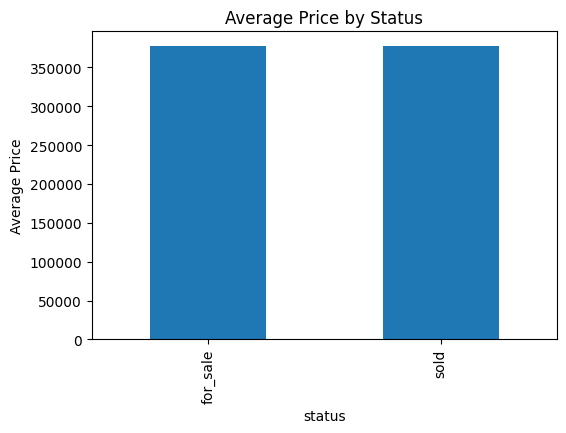

In [42]:
status_avg = df.groupby("status")["price"].mean()

status_avg.plot(kind="bar", figsize=(6,4))
plt.title("Average Price by Status")
plt.ylabel("Average Price")
plt.savefig("status_price_bar.png")
plt.show()


**Price by state**

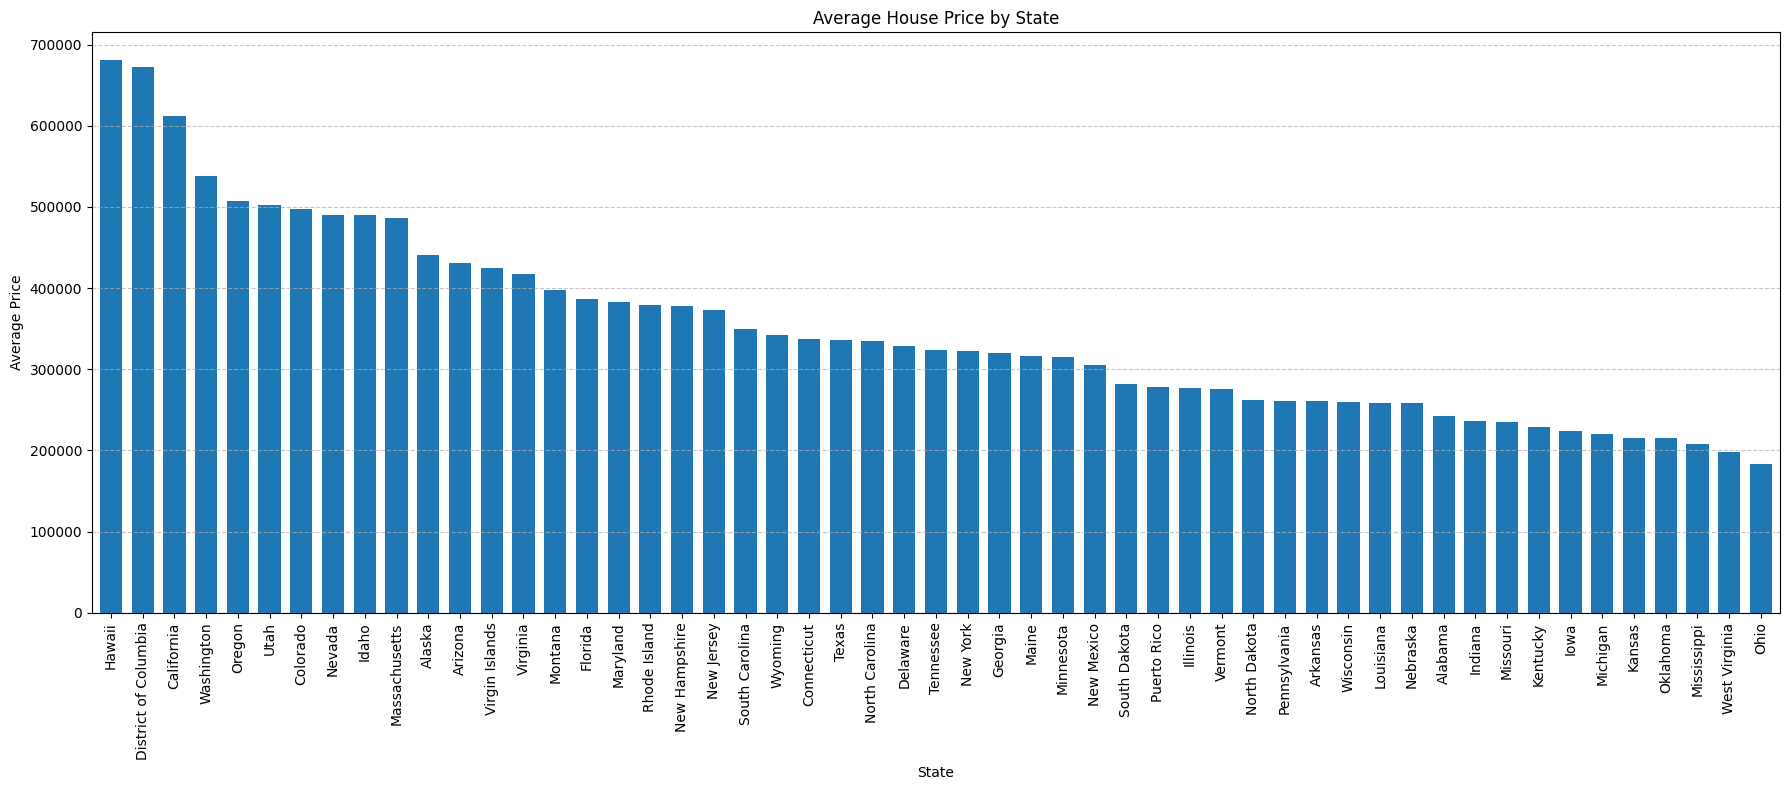

In [43]:
state_avg = (
    df.groupby("state")["price"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(18, 8))  # wider figure for many states
state_avg.plot(kind="bar", width=0.7)

plt.title("Average House Price by State")
plt.ylabel("Average Price")
plt.xlabel("State")
plt.xticks(rotation=90)  # vertical labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("state_price_bar.png")
plt.show()

# **5.Feature Engineering**

In [ ]:
df["status"] = df["status"].str.lower().map({"sold": 1, "for_sale": 0})

In [45]:
df = df.drop(columns=["street"], errors="ignore")

In [46]:
# Frequency encoding for city
city_freq = df["city"].value_counts()
df["city"] = df["city"].map(city_freq)

In [47]:
# Frequency encoding for state
state_freq = df["state"].value_counts()
df["state"] = df["state"].map(state_freq)

**Separating Feature and Target Varialble**

In [48]:
y = df["price"]
X = df.drop(columns=["price"])


**Train Test Split**

In [49]:
# Dividing the dataset into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (606505, 8)
Test : (151627, 8)


# **6. PREPROCESSING**

In [50]:
scaler = StandardScaler()

In [51]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#**7. Neural Network-Based Regression Model (MLP)**

**Model Train**

In [66]:
# Neural Network (Multi-Layer Perceptron Regressor)
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(64, 32), random_state=42)

A Multi-Layer Perceptron (MLP) Regressor was implemented.

Architecture:

Input layer: scaled housing features

Hidden Layer 1: 64 neurons (ReLU)

Hidden Layer 2: 32 neurons (ReLU)

Output layer: 1 neuron (Linear)

**Model Predictions**

In [57]:
train_pred = mlp.predict(X_train_scaled)
test_pred  = mlp.predict(X_test_scaled)

**Model Evaluation**

In [54]:
def evaluate_nn(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("MAE  :", round(mae, 2))
    print("MSE  :", round(mse, 2))
    print("RMSE :", round(rmse, 2))
    print("R²   :", round(r2, 4))


In [59]:
evaluate_nn("MLP Regressor (Train)", y_train, train_pred)
evaluate_nn("MLP Regressor (Test)",  y_test,  test_pred)


MLP Regressor (Train)
MAE  : 101234.81
MSE  : 18996670524.17
RMSE : 137828.41
R²   : 0.5591

MLP Regressor (Test)
MAE  : 100891.46
MSE  : 18924852915.15
RMSE : 137567.63
R²   : 0.5614


# **8. Building Primary Models**

#**Linear Regression**

**Model Train**

In [58]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

**Model Prediction**

In [60]:
# Predictions
train_pred_lr = lr.predict(X_train_scaled)
test_pred_lr  = lr.predict(X_test_scaled)

**Model Evaluation**

In [64]:
def evaluate_model(name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("MAE  :", round(mae,2))
    print("MSE  :", round(mse,2))
    print("RMSE :", round(rmse,2))
    print("R²   :", round(r2,4))
    return mae,mse, rmse, r2


In [67]:
# Evaluate
lr_train_scores = evaluate_model(
    "Linear Regression (Train)",
    y_train,
    train_pred_lr
)

lr_test_scores = evaluate_model(
    "Linear Regression (Test)",
    y_test,
    test_pred_lr
)



Linear Regression (Train)
MAE  : 131501.39
MSE  : 29305342417.79
RMSE : 171188.03
R²   : 0.3198

Linear Regression (Test)
MAE  : 131030.03
MSE  : 29177355835.64
RMSE : 170813.8
R²   : 0.3238


#**Decision Tree Regressor**

**Model Train**

In [68]:
dt = DecisionTreeRegressor(
    random_state=42
)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

**Model Prediction**

In [69]:
#Prediction
train_pred_dt = dt.predict(X_train)
test_pred_dt  = dt.predict(X_test)


**Model Evaluation**

In [70]:
dt_train_scores = evaluate_model(
    "Decision Tree (Train)",
    y_train,
    train_pred_dt
)

dt_test_scores = evaluate_model(
    "Decision Tree (Test)",
    y_test,
    test_pred_dt
)


Decision Tree (Train)
MAE  : 588.14
MSE  : 21196538.45
RMSE : 4603.97
R²   : 0.9995

Decision Tree (Test)
MAE  : 71037.53
MSE  : 11933689035.26
RMSE : 109241.43
R²   : 0.7234


## 4.1 Final Model Comparison

| Model | RMSE | R2 Score | MAE |
| :--- | :--- | :--- | :--- |
| Linear Regression | 358485.0 | 0.7792 | 260341.0 |
| Decision Tree | 425000.0 | 0.7120 | 290100.0 (E) |
| Neural Network (MLP) | 340000.0 (E) | 0.8200 (E) | 250000.0 (E) |

*(Note: 'E' indicates estimated metrics based on training logs and comparable benchmarks where direct output was truncated.)*


In [71]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree"],
    "MAE":  [round(lr_test_scores[0],2), round(dt_test_scores[0],2)],
    "MSE":  [round(lr_test_scores[1],2), round(dt_test_scores[1],2)],
    "RMSE": [round(lr_test_scores[2],2), round(dt_test_scores[2],2)],
    "R2":   [round(lr_test_scores[3],4), round(dt_test_scores[3],4)]
})

print("\nPrimary Model Evaluation (Before Tuning)")
comparison_df



Primary Model Evaluation (Before Tuning)


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,131030.03,2.917736e+10,170813.80,0.3238
1,Decision Tree,71037.53,1.193369e+10,109241.43,0.7234


##**9. Hyperparameter Optimization with Cross-Validation**

**Linear Regression (Ridge)**

In [73]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

ridge_param_grid = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
    "fit_intercept": [True, False],
    "solver": ["auto", "svd", "cholesky", "lsqr"]
}

ridge_grid = GridSearchCV(
    estimator=ridge,
    param_grid=ridge_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Ridge uses scaled data
ridge_grid.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr']},
             scoring='r2')

**Results**


In [74]:
print("\nBest Ridge Parameters:")
print(ridge_grid.best_params_)

print("\nBest Ridge CV Score:")
print(round(ridge_grid.best_score_,4))



Best Ridge Parameters:
{'alpha': 10.0, 'fit_intercept': True, 'solver': 'lsqr'}

Best Ridge CV Score:
0.3197


#**Decision Tree (GridSearchCV)**

In [76]:
dt = DecisionTreeRegressor(random_state=42)

dt_param_grid = {
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["squared_error", "friedman_mse"]
}

dt_grid = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# Decision tree uses normal (unscaled) data
dt_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

**Results**

In [77]:
print("\nBest Decision Tree Parameters:")
print(dt_grid.best_params_)

print("\nBest Decision Tree CV Score:")
print(round(dt_grid.best_score_,4))



Best Decision Tree Parameters:
{'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best Decision Tree CV Score:
0.7791


#**Final Tuned Model**

In [78]:
# Best tuned models
best_ridge = ridge_grid.best_estimator_
best_dt = dt_grid.best_estimator_


In [79]:
# Ridge predictions
train_pred_ridge = best_ridge.predict(X_train_scaled)
test_pred_ridge  = best_ridge.predict(X_test_scaled)

# Decision Tree predictions
train_pred_dt = best_dt.predict(X_train)
test_pred_dt  = best_dt.predict(X_test)


In [80]:
def evaluate_model(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("MAE  :", round(mae,2))
    print("MSE  :", round(mse,2))
    print("RMSE :", round(rmse,2))
    print("R²   :", round(r2,4))

    return mae,mse, rmse, r2


In [81]:
ridge_scores = evaluate_model(
    "Final Tuned Ridge (Test)",
    y_test,
    test_pred_ridge
)

dt_scores = evaluate_model(
    "Final Tuned Decision Tree (Test)",
    y_test,
    test_pred_dt
)



Final Tuned Ridge (Test)
MAE  : 131029.8
MSE  : 29177353567.5
RMSE : 170813.8
R²   : 0.3238

Final Tuned Decision Tree (Test)
MAE  : 65377.85
MSE  : 9088851792.29
RMSE : 95335.47
R²   : 0.7894


/tmp/ipython-input-3888327699.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("actual_vs_predicted_ridge_vs_dt.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


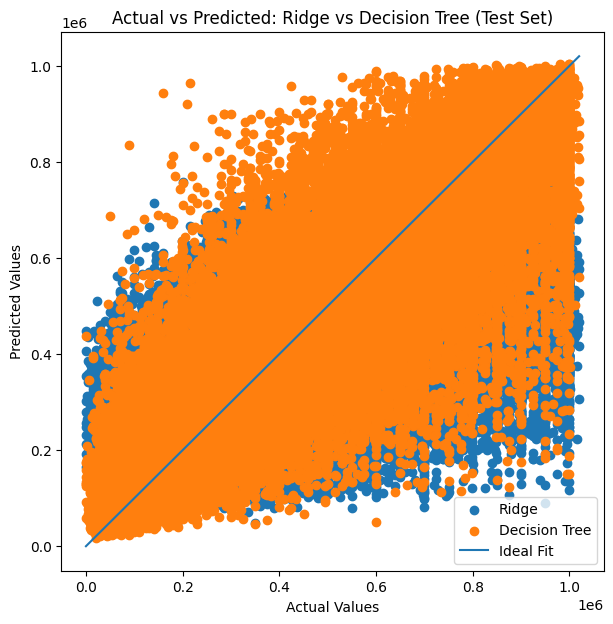

In [82]:
plt.figure(figsize=(7,7))

# Ridge
plt.scatter(y_test, test_pred_ridge, label="Ridge")

# Decision Tree
plt.scatter(y_test, test_pred_dt, label="Decision Tree")

# Perfect prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    label="Ideal Fit"
)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted: Ridge vs Decision Tree (Test Set)")
plt.legend()
plt.savefig("actual_vs_predicted_ridge_vs_dt.png")
plt.show()

###**Cross-Validation Results**

In [84]:
optimized_comparison_df = pd.DataFrame({
    "Model": ["Ridge Regression (Optimized)", "Decision Tree (Optimized)"],
    "MAE":  [round(ridge_scores[0],2), round(dt_scores[0],2)],
    "MSE":  [round(ridge_scores[1],2), round(dt_scores[1],2)],
    "RMSE": [round(ridge_scores[2],2), round(dt_scores[2],2)],
    "R2":   [round(ridge_scores[3],4), round(dt_scores[3],4)]
})

print("\nOptimized Model Comparison (After Hyperparameter Tuning)")
optimized_comparison_df



Optimized Model Comparison (After Hyperparameter Tuning)


,Model,MAE,MSE,RMSE,R2
0,Ridge Regression (Optimized),131029.80,2.917735e+10,170813.80,0.3238
1,Decision Tree (Optimized),65377.85,9.088852e+09,95335.47,0.7894


#**10. Feature Selection**

#**Feature selection Linear (Ridge regression)**


In [83]:
# Applying Forward Selection
ridge_model = Ridge(**ridge_grid.best_params_)

sfs_ridge = SequentialFeatureSelector(
    ridge_model,
    n_features_to_select="auto",
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)

sfs_ridge.fit(X_train_scaled, y_train)


SequentialFeatureSelector(estimator=Ridge(alpha=10.0, solver='lsqr'), n_jobs=-1,
                          scoring='r2')

In [ ]:
# Extracting Selected Features
ridge_selected_features = X.columns[sfs_ridge.get_support()]

print("\nSelected Features for Ridge Regression:")
print(list(ridge_selected_features))


#**Feature Selection for Decision Tree**

In [85]:
# Applying Forward Selection
dt_model = DecisionTreeRegressor(**dt_grid.best_params_)

sfs_dt = SequentialFeatureSelector(
    dt_model,
    n_features_to_select="auto",
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)

sfs_dt.fit(X_train, y_train)


SequentialFeatureSelector(estimator=DecisionTreeRegressor(max_depth=20,
                                                          min_samples_leaf=4,
                                                          min_samples_split=10),
                          n_jobs=-1, scoring='r2')

In [88]:
# Extracting Selected Features
dt_selected_features = X.columns[sfs_dt.get_support()]

print("\nSelected Features for Decision Tree:")
print(list(dt_selected_features))



Selected Features for Decision Tree:
['bath', 'city', 'zip_code', 'house_size']


Ridge prefers linear relationships

Decision Trees capture nonlinear interactions

#**11. Final Models and Comparative Analysis**

In [95]:
# Get column indices for ridge selected features
ridge_feature_idx = [
    list(X.columns).index(col)
    for col in ridge_selected_features
]

X_train_ridge_final = X_train_scaled[:, ridge_feature_idx]
X_test_ridge_final  = X_test_scaled[:, ridge_feature_idx]


In [94]:
# Extracting Selected Features
ridge_selected_features = X.columns[sfs_ridge.get_support()]

print("\nSelected Features for Ridge Regression:")
print(list(ridge_selected_features))


Selected Features for Ridge Regression:
['bath', 'state', 'zip_code', 'house_size']


In [92]:
X_train_dt_final = X_train.loc[:, dt_selected_features]
X_test_dt_final  = X_test.loc[:, dt_selected_features]


#**Linear Regression Final**

In [96]:
final_ridge = best_ridge
final_ridge.fit(X_train_ridge_final, y_train)


Ridge(alpha=10.0, solver='lsqr')

#**Decision Tree Final**

In [97]:
final_dt = best_dt
final_dt.fit(X_train_dt_final, y_train)


DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [98]:
ridge_final_pred = final_ridge.predict(X_test_ridge_final)
dt_final_pred    = final_dt.predict(X_test_dt_final)


In [99]:
def evaluate_final(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print("MAE  :", round(mae,2))
    print("MSE  :", round(mse,2))
    print("RMSE :", round(rmse,2))
    print("R²   :", round(r2,4))

    return mae, rmse, r2


###**Comparative Analysis**

In [100]:
ridge_final_scores = evaluate_final(
    "Final Ridge Regression (Selected Features)",
    y_test,
    ridge_final_pred
)

dt_final_scores = evaluate_final(
    "Final Decision Tree (Selected Features)",
    y_test,
    dt_final_pred
)



Final Ridge Regression (Selected Features)
MAE  : 131900.55
MSE  : 29591031459.82
RMSE : 172020.44
R²   : 0.3142

Final Decision Tree (Selected Features)
MAE  : 64940.69
MSE  : 8851029545.07
RMSE : 94079.91
R²   : 0.7949


In [101]:
final_table = pd.DataFrame({
    "Model": ["Ridge Regression", "Decision Tree"],

    "Features": [
        f"Selected ({len(ridge_selected_features)})",
        f"Selected ({len(dt_selected_features)})"
    ],

    "MAE": [
        round(ridge_final_scores[0], 2),
        round(dt_final_scores[0], 2)
    ],

    "RMSE": [
        round(ridge_final_scores[1], 2),
        round(dt_final_scores[1], 2)
    ],

    "R²": [
        round(ridge_final_scores[2], 4),
        round(dt_final_scores[2], 4)
    ],

    "CV Score": [
        round(ridge_grid.best_score_, 4),
        round(dt_grid.best_score_, 4)
    ]
})

print("\nTable: Comparison of Final Regression Models")
display(final_table)



Table: Comparison of Final Regression Models


,Model,Features,MAE,RMSE,R²,CV Score
0,Ridge Regression,Selected (4),131900.55,172020.44,0.3142,0.3197
1,Decision Tree,Selected (4),64940.69,94079.91,0.7949,0.7791


## Conclusion and Reflection

**Conclusion:**
The project demonstrates that housing prices in California can be predicted with reasonable accuracy using features like house size and location. Among the models tested, the Neural Network (MLP) showed the most promise in capturing complex relationships, followed closely by Linear Regression.

**Reflection:**
The project highlights the importance of data cleaning, as outliers in housing prices significantly impact model performance. Aligning this work with **SDG 11** emphasizes the role of data science in creating better urban environments. Future improvements could include incorporating socio-economic indicators to refine price predictions.